Por favor, ingrese el símbolo del activo (ej. 'BTC-USD', 'GOOGL'). Puede encontrar estos símbolos en el sitio web de Yahoo Finance:  BTC-USD


Descargando datos para BTC-USD...


C:\Users\josep\AppData\Local\Temp\ipykernel_23572\3851528062.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.ticker, start=self.start_date)
[*********************100%***********************]  1 of 1 completed


Calculando indicadores técnicos...
Preparando datos para el modelo de Machine Learning...
Entrenando y optimizando el modelo HistGradientBoostingClassifier con GridSearchCV...
Mejores parámetros encontrados: {'learning_rate': 0.2, 'max_iter': 200, 'max_leaf_nodes': 31}

--- Evaluación del modelo en el conjunto de prueba ---
Precisión (Accuracy): 0.53

Matriz de Confusión:
[[281  95]
 [266 128]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.51      0.75      0.61       376
           1       0.57      0.32      0.41       394

    accuracy                           0.53       770
   macro avg       0.54      0.54      0.51       770
weighted avg       0.54      0.53      0.51       770


--- Señales de Trading recientes ---
Price               Close Target Prediction          Signal
Ticker            BTC-USD                                  
Date                                                       
2025-08-22  116874.085938     

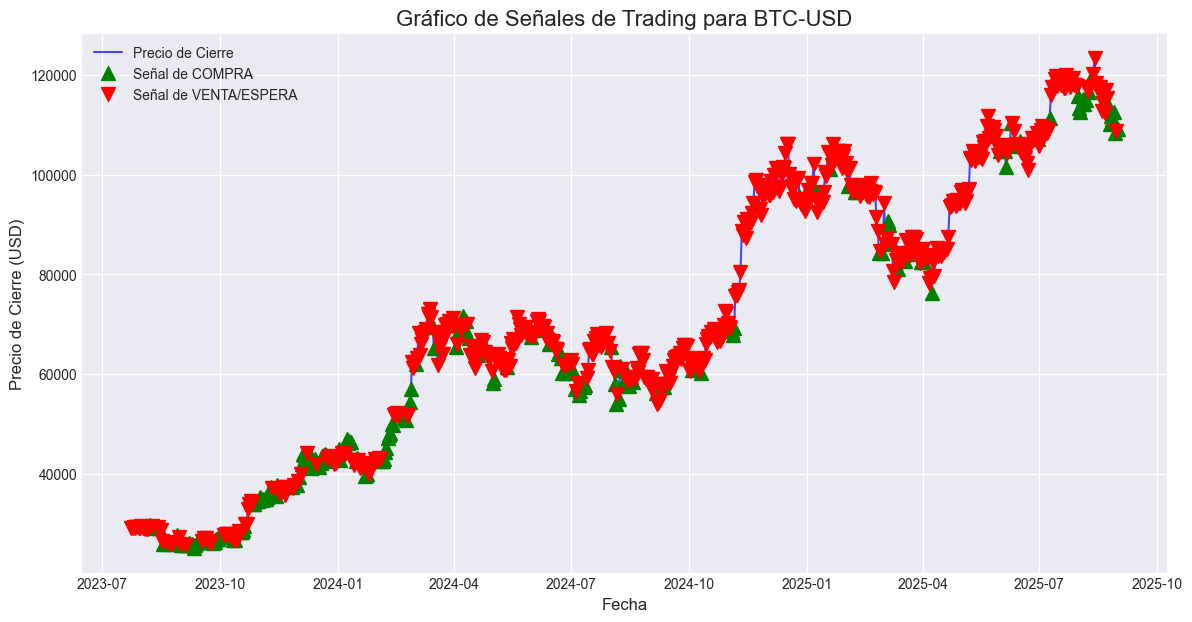

Gráfico generado exitosamente.


In [ ]:
# -*- coding: utf-8 -*-
"""
Bot de Trading con Machine Learning (Python)

Este bot de trading utiliza un modelo de Machine Learning (HistGradientBoostingClassifier) 
para predecir la dirección del precio de un activo (subida o bajada) basándose en 
indicadores técnicos. El bot no sigue reglas rígidas, sino que aprende patrones 
históricos para generar señales de compra o venta.

Funcionalidades agregadas:
- El usuario puede ingresar el símbolo del activo a analizar.
- Se genera una gráfica de precios con las señales de trading (COMPRAR/VENDER).
- Se ha añadido un backtesting avanzado para simular el rendimiento de la estrategia,
  incluyendo comisiones, stop-loss, take-profit y métricas de riesgo.
- El modelo se optimiza con GridSearchCV para encontrar los mejores parámetros.
- Se han añadido más indicadores técnicos, escalado de datos y balanceo de clases para mejorar la precisión.
"""

import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
from tensorflow import keras
from tensorflow.keras import layers, callbacks

class TradingBot:
    def __init__(self, ticker, start_date):
        self.ticker = ticker
        self.start_date = start_date
        self.data = None
        self.model = None
        self.X_test = None
        self.y_test = None
        self.predictions_test = None

    def get_data(self):
        """
        Descarga datos históricos de un ticker de Yahoo Finance.
        """
        print(f"Descargando datos para {self.ticker}...")
        try:
            # Eliminar end_date para descargar datos hasta el día más reciente.
            data = yf.download(self.ticker, start=self.start_date)
            if data.empty:
                print(f"Error: No se encontraron datos para el ticker '{self.ticker}'. Verifique el símbolo.")
                self.data = None
            else:
                self.data = data
        except Exception as e:
            print(f"Error al descargar los datos para {self.ticker}: {e}")
            self.data = None

    def calculate_indicators(self):
        """
        Calcula varios indicadores técnicos y los agrega como nuevas columnas.
        """
        print("Calculando indicadores técnicos...")
        
        data = self.data.copy()
        
        # Simple Moving Average (SMA)
        data['SMA_20'] = data['Close'].rolling(window=20).mean()
        data['SMA_50'] = data['Close'].rolling(window=50).mean()
        
        # Exponential Moving Average (EMA)
        data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
        data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
        
        # Moving Average Convergence Divergence (MACD)
        data['MACD'] = data['EMA_12'] - data['EMA_26']
        data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
        
        # Relative Strength Index (RSI)
        delta = data['Close'].diff(1)
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        data['RSI'] = 100 - (100 / (1 + rs))

        # Bollinger Bands (BBands)
        data['BB_MA'] = data['Close'].rolling(window=20).mean()
        data['BB_STD'] = data['Close'].rolling(window=20).std()
        data['Upper_BB'] = data['BB_MA'] + (data['BB_STD'] * 2)
        data['Lower_BB'] = data['BB_MA'] - (data['BB_STD'] * 2)
        
        # Volatility (standard deviation)
        data['Volatility'] = data['Close'].rolling(window=20).std()
        
        # Money Flow Index (MFI)
        typical_price = (data['High'] + data['Low'] + data['Close']) / 3
        money_flow = typical_price * data['Volume']
        
        positive_flow = money_flow.where(data['Close'].diff(1) > 0, 0)
        negative_flow = money_flow.where(data['Close'].diff(1) < 0, 0)
        
        positive_mf = positive_flow.rolling(window=14).sum()
        negative_mf = negative_flow.rolling(window=14).sum()
        
        mfi_ratio = positive_mf / negative_mf
        data['MFI'] = 100 - (100 / (1 + mfi_ratio))
        
        # Average Directional Index (ADX)
        plus_dm = data['High'].diff().where(data['High'].diff() > data['Low'].diff(), 0)
        minus_dm = data['Low'].diff().where(data['Low'].diff() > data['High'].diff(), 0)
        tr = data['High'] - data['Low']
        
        plus_di = 100 * (plus_dm.ewm(alpha=1/14, adjust=False).mean() / tr.ewm(alpha=1/14, adjust=False).mean())
        minus_di = 100 * (minus_dm.ewm(alpha=1/14, adjust=False).mean() / tr.ewm(alpha=1/14, adjust=False).mean())
        
        adx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di).ewm(alpha=1/14, adjust=False).mean()
        data['ADX'] = adx

        self.data = data

    def prepare_data(self):
        """
        Prepara los datos para el modelo de ML, definiendo las variables 
        (features y target).
        """
        print("Preparando datos para el modelo de Machine Learning...")
        
        # Definir la variable objetivo (target)
        # 1 si el precio sube al día siguiente, 0 si baja.
        self.data['Target'] = (self.data['Close'].shift(-1) > self.data['Close']).astype(int)
        
        # Eliminar las filas con valores nulos que se generaron al calcular los indicadores
        self.data.dropna(inplace=True)
        
        # Definir las variables de entrada (features)
        features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'SMA_50', 
                    'MACD', 'MACD_Signal', 'RSI', 'Volatility', 'Upper_BB', 'Lower_BB', 'MFI', 'ADX']
        
        X = self.data[features]
        y = self.data['Target']

        # Escalar los datos de características
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Dividir los datos en conjuntos de entrenamiento y prueba
        # Usaremos 80% para entrenamiento y 20% para prueba
        split_ratio = 0.8
        split_index = int(len(X) * split_ratio)
        
        self.X_train = X_scaled[:split_index]
        self.y_train = y[:split_index]
        
        self.X_test = X_scaled[split_index:]
        self.y_test = y[split_index:]

        # Guardar las características sin escalar para el backtesting
        self.X_test_unscaled = X[split_index:].copy()

    def train_model(self):
        """
        Entrena el modelo HistGradientBoostingClassifier con GridSearchCV.
        """
        print("Entrenando y optimizando el modelo HistGradientBoostingClassifier con GridSearchCV...")
        
        # Definir la cuadrícula de parámetros para la búsqueda
        param_grid = {
            'learning_rate': [0.05, 0.1, 0.2],
            'max_iter': [100, 200],
            'max_leaf_nodes': [31, 63],
        }
        
        # Configurar la búsqueda de la cuadrícula con el nuevo modelo y balanceo de clases
        grid_search = GridSearchCV(
            HistGradientBoostingClassifier(random_state=42), 
            param_grid, 
            cv=3, 
            scoring='accuracy',
            n_jobs=-1
        )
        
        # Entrenar el modelo con la búsqueda de cuadrícula
        grid_search.fit(self.X_train, self.y_train)
        self.model = grid_search.best_estimator_
        
        print("Mejores parámetros encontrados:", grid_search.best_params_)

        # Hacer predicciones en el conjunto de prueba
        self.predictions_test = self.model.predict(self.X_test)

    def evaluate_model(self):
        """
        Evalúa el rendimiento del modelo en el conjunto de prueba.
        """
        print("\n--- Evaluación del modelo en el conjunto de prueba ---")
        accuracy = accuracy_score(self.y_test, self.predictions_test)
        print(f"Precisión (Accuracy): {accuracy:.2f}")
        
        print("\nMatriz de Confusión:")
        print(confusion_matrix(self.y_test, self.predictions_test))
        
        print("\nReporte de Clasificación:")
        print(classification_report(self.y_test, self.predictions_test))

    def backtest_strategy(self, initial_capital=1000):
        """
        Realiza un backtesting avanzado para evaluar el rendimiento de la estrategia.
        Incluye comisiones, stop-loss y take-profit.
        
        Args:
            initial_capital (float): Capital inicial para el backtesting.
            
        Returns:
            dict: Un diccionario con las métricas de rendimiento.
        """
        print("Realizando backtesting avanzado...")
        capital = initial_capital
        position = 0  # 0 = sin posición, 1 = en posición
        buy_price = 0
        trades_count = 0
        pnl_history = [initial_capital]
        
        COMMISSION = 0.001  # 0.1% de comisión por operación
        STOP_LOSS = 0.95
        TAKE_PROFIT = 1.10
        
        for i in range(len(self.predictions_test)):
            current_price = self.X_test_unscaled['Close'].iloc[i].item()

            # Si estamos en una posición y el precio cae a nuestro stop-loss o sube a take-profit
            if position == 1:
                if current_price <= buy_price * STOP_LOSS:
                    sell_price = current_price
                    profit = (sell_price - buy_price) / buy_price
                    capital += capital * profit - (capital * profit * COMMISSION)
                    position = 0
                    print(f"Stop-Loss activado en el día {self.X_test_unscaled.index[i].strftime('%Y-%m-%d')}")
                elif current_price >= buy_price * TAKE_PROFIT:
                    sell_price = current_price
                    profit = (sell_price - buy_price) / buy_price
                    capital += capital * profit - (capital * profit * COMMISSION)
                    position = 0
                    print(f"Take-Profit activado en el día {self.X_test_unscaled.index[i].strftime('%Y-%m-%d')}")
            
            # Si no hay posición, revisamos la señal
            if position == 0 and self.predictions_test[i] == 1:
                position = 1
                buy_price = current_price
                trades_count += 1
                capital -= capital * COMMISSION
            
            pnl_history.append(capital)

        # Si el bot tiene una posición abierta al final, la cerramos
        if position == 1:
            sell_price = self.X_test_unscaled['Close'].iloc[-1].item()
            profit = (sell_price - buy_price) / buy_price
            capital += capital * profit - (capital * profit * COMMISSION)

        pnl_history = np.array(pnl_history)
        total_profit_loss = capital - initial_capital
        
        # Calcular Max Drawdown
        peaks = np.maximum.accumulate(pnl_history)
        drawdowns = (peaks - pnl_history) / peaks
        max_drawdown = np.max(drawdowns) if len(drawdowns) > 0 else 0

        return {
            "initial_capital": initial_capital,
            "final_capital": float(capital),
            "total_profit_loss": float(total_profit_loss),
            "trades_count": trades_count,
            "max_drawdown": float(max_drawdown)
        }

    def plot_signals(self):
        """
        Genera un gráfico que muestra el precio de cierre y las señales de trading.
        """
        print("Generando gráfico de señales...")
        plt.style.use('seaborn-v0_8-darkgrid')
        plt.figure(figsize=(14, 7))
        plt.plot(self.X_test_unscaled.index, self.X_test_unscaled['Close'], label='Precio de Cierre', color='blue', alpha=0.7)

        buy_signals = self.X_test_unscaled.loc[self.predictions_test == 1]
        sell_signals = self.X_test_unscaled.loc[self.predictions_test == 0]

        plt.plot(buy_signals.index, buy_signals['Close'], '^', markersize=10, color='green', label='Señal de COMPRA')
        plt.plot(sell_signals.index, sell_signals['Close'], 'v', markersize=10, color='red', label='Señal de VENTA/ESPERA')

        plt.title(f'Gráfico de Señales de Trading para {self.ticker}', fontsize=16)
        plt.xlabel('Fecha', fontsize=12)
        plt.ylabel('Precio de Cierre (USD)', fontsize=12)
        plt.legend()
        plt.show()
        print("Gráfico generado exitosamente.")

    def download_data(self):
        """
        Guarda el DataFrame en un archivo CSV.
        """
        filename = f'trading_data_{self.ticker}_{pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")}.csv'
        self.data.to_csv(filename)
        print(f"Los datos se han guardado en el archivo: {filename}")

    def run(self):
        """
        Función principal para ejecutar el bot de trading.
        """
        self.get_data()
        if self.data is None:
            return

        self.calculate_indicators()
        
        self.prepare_data()
        if self.X_test_unscaled.empty:
            print("Error: No hay suficientes datos para procesar después de calcular los indicadores.")
            return

        self.train_model()
        self.evaluate_model()
        
        # Generar y mostrar señales de trading recientes
        print("\n--- Señales de Trading recientes ---")
        recent_data = self.data.iloc[-10:].copy()
        
        # Escalar solo los datos recientes para la predicción
        scaler_temp = StandardScaler()
        scaler_temp.fit(self.data[self.X_test_unscaled.columns].iloc[:-1])
        recent_features_scaled = scaler_temp.transform(recent_data[self.X_test_unscaled.columns])
        
        recent_predictions = self.model.predict(recent_features_scaled)
        
        recent_data['Prediction'] = recent_predictions
        recent_data['Signal'] = recent_data['Prediction'].apply(lambda x: 'COMPRAR' if x == 1 else 'VENDER/ESPERAR')
        
        print(recent_data[['Close', 'Target', 'Prediction', 'Signal']])
        print("\nNota: 'Target' muestra el resultado real futuro, 'Prediction' es lo que el modelo predijo.")

        # Realizar el backtesting y mostrar los resultados
        print("\n--- Resultados del Backtesting (simulación) ---")
        results = self.backtest_strategy()
        
        print(f"Capital inicial: ${results['initial_capital']:.2f}")
        print(f"Capital final: ${results['final_capital']:.2f}")
        print(f"Ganancia/Pérdida Total: ${results['total_profit_loss']:.2f}")
        print(f"Número de operaciones (compras): {results['trades_count']}")
        print(f"Reducción máxima (Max Drawdown): {results['max_drawdown']:.2%}")
        
        # Graficar los resultados
        self.plot_signals()

        # Ofrecer la descarga de datos
        descargar = input("\n¿Desea descargar los datos procesados en un archivo CSV? (s/n): ").lower()
        if descargar == 's':
            self.download_data()
            
if __name__ == "__main__":
    ticker_input = input("Por favor, ingrese el símbolo del activo (ej. 'BTC-USD', 'GOOGL'). Puede encontrar estos símbolos en el sitio web de Yahoo Finance: ").upper()
    bot = TradingBot(ticker=ticker_input, start_date='2015-01-01')
    bot.run()
